---
# Tutoriel 3 - Classificateur CNN
---

<center><img src="./img/mlprocess_3.png" alt="Processus d'apprentissage automatique" width="50%"/></center>

Dans ce tutoriel, nous allons concevoir un réseau de neurones à convolution pour faire de la classification d'images. À cette fin, nous utilisons le jeu de données CIFAR10 qui est plus complexe que celui de MNIST.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import torch
import numpy as np
from torch import optim, nn
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets.cifar import CIFAR10
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F

from poutyne.framework import Model, ModelCheckpoint, Callback, CSVLogger, EarlyStopping, ReduceLROnPlateau
from poutyne import torch_to_numpy
from torchvision.utils import make_grid

torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Hyperparamètres d'entraînement
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")
batch_size = 32
learning_rate = 0.01
n_epoch = 5
num_classes = 10

In [3]:
def load_cifar10(download=False, path='./', transform=None):
    """Loads the cifar10 dataset.

    :param download: Download the dataset
    :param path: Folder to put the dataset
    :return: The train and test dataset
    """
    train_dataset = CIFAR10(path, train=True, download=download, transform=transform)
    test_dataset = CIFAR10(path, train=False, download=download, transform=transform)
    return train_dataset, test_dataset


def load_cifar10_with_validation_set(download=False, path='./', train_split=0.8):
    """Loads the CIFAR10 dataset.

    :param download: Download the dataset
    :param path: Folder to put the dataset
    :return: The train, valid and test dataset ready to be ingest in a neural network
    """
    norm_coefs = {}
    norm_coefs['imagenet'] = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(*norm_coefs['imagenet'])
    ])
    train, test = load_cifar10(download, path, transform=transform)
    lengths = [round(train_split*len(train)), round((1.0-train_split)*len(train))]
    train, valid = random_split(train, lengths)
    return train, valid, test

def show_cifar10_examples(download=False, path='./'):
    train, _ = load_cifar10(download, path)
    num_lines = 3
    plt.figure(figsize=(20,20*num_lines/3))
    for i in range(num_lines*3):
        plt.subplot(num_lines, 3, i + 1)
        plt.imshow(train[i][0])
        plt.title('Étiquette: %d' % train[i][1])
    plt.show()

def count_number_of_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

Regardons quelques exemples d'images provenant du jeu de données. L'étiquette indiquée au-dessus de chaque image correspond au numéro qui est attribué à la classe de l'objet.

Files already downloaded and verified
Files already downloaded and verified


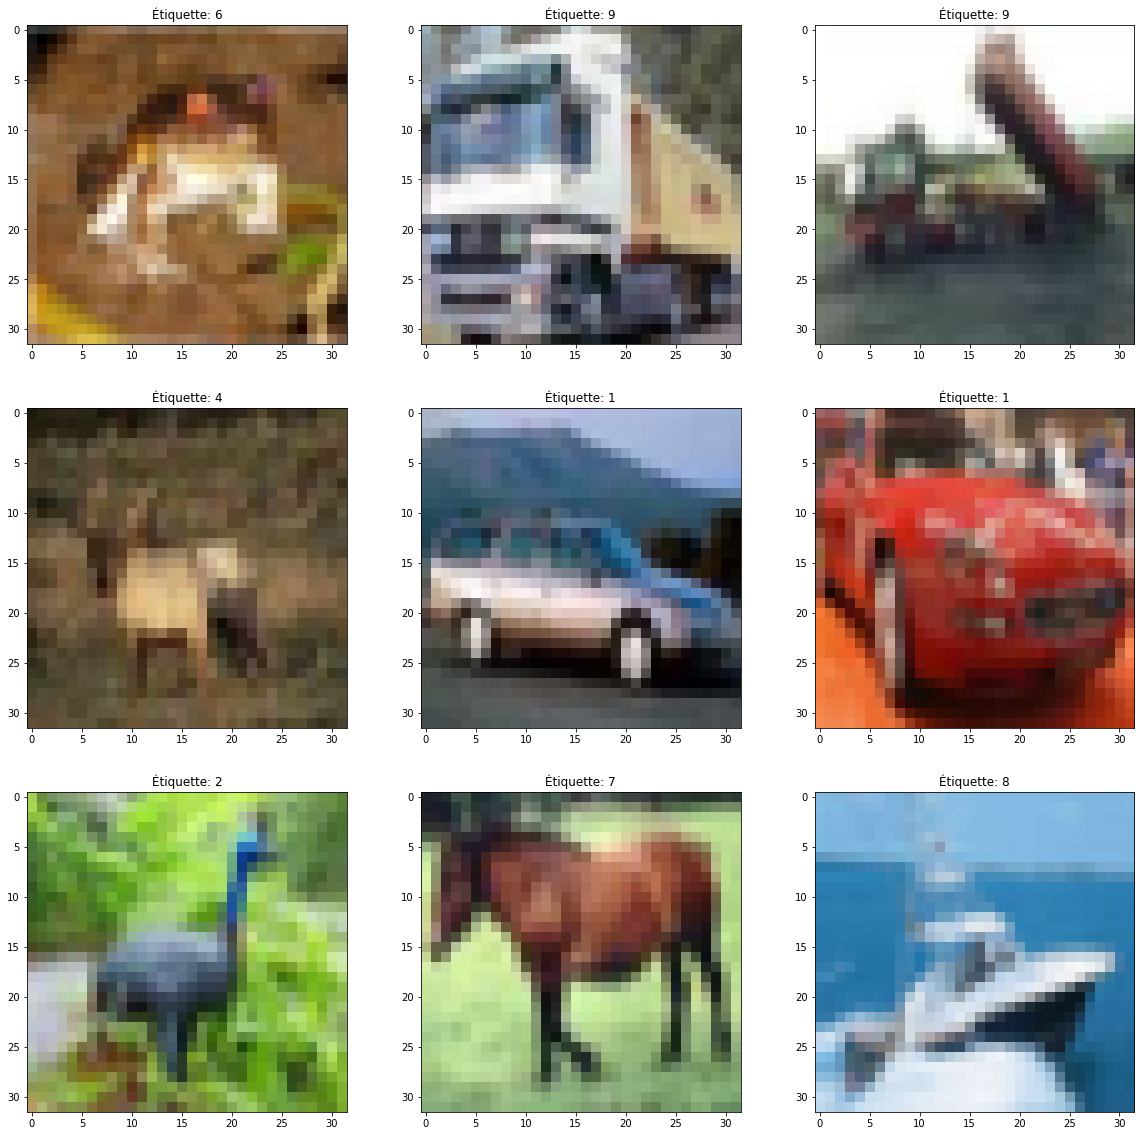

In [4]:
show_cifar10_examples(download=True)

In [5]:
train, valid, test = load_cifar10_with_validation_set(download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Nombres d'images dans les ensembles d'entraînement, de validation et de test.
len(train), len(valid), len(test)

(40000, 10000, 10000)

Nous définissons des chargeurs de données (`dataloaders`) qui vont nous fournir `batch_size` images à la fois, c'est-à-dire des lots (`batchs`) de taille `batch_size`. Nous avons 3  chargeurs de données pour les 3 ensembles utilisés: entraînement, validation et test.

In [7]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

In [8]:
def train(name, network, params=None):
    print(network)
    if not params:
        params = network.parameters()

    optimizer = optim.SGD(params, lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    
    early_stopping = EarlyStopping(patience=5, verbose=True)
    lr_scheduler = ReduceLROnPlateau(patience=2, verbose=True)
    callbacks = [early_stopping, lr_scheduler]

    # Objet Model de Poutyne
    model = Model(network, optimizer, loss_function, batch_metrics=['accuracy'])

    # Envoi du modèle sur GPUs si disponibles
    model.to(device)

    # Lancement de l'entraînement
    model.fit_generator(train_loader, valid_loader, epochs=n_epoch, callbacks=callbacks)
    return model

Le code suivant implémente, de manière orientée objet, le réseau de neurones à convolution tel que résumé dans le tableau ci-dessous. En commentaire dans le code, nous avons mis les dimensions du tenseur `x` à chaque état du réseau. Remarquez que ce réseau a beaucoup plus de composantes que ceux des tutoriels précédents.

| Type de couche                                     | Taille en sortie |     # de paramètres     |
|------------------------------------------------|:-----------:|:-----------------------:|
| Input                                          |   3x224x224   |            0            |
| **Conv avec 10 filtres 3x3 avec padding de 1** |   10x224x224  |      10\*3\*3\*3 +10 = 280     |
| **BatchNorm avec transformation affine**       |   10x224x224  |      10 + 10 = 20     |
| ReLU                                           |   10x224x224  |            0            |
| MaxPool 2x2                                    |   10x112x112  |            0            |
| **Conv avec 50 filtres 3x3 avec padding de 1** |   50x112x112  |      50\*10\*3\*3 + 50 = 4 550     |
| **BatchNorm avec transformation affine**       |   50x112x112  |      50 + 50 = 100     |
| ReLU                                           |   50x112x112  |            0            |
| MaxPool 2x2                                    |   50x56x56  |            0            |
| **Conv avec 150 filtres 3x3 avec padding de 1** |  150x56x56  |      150\*50\*3\*3 + 150 = 67 650     |
| **BatchNorm avec transformation affine**       |   150x56x56  |      150 + 150 = 300     |
| ReLU                                           |   150x56x56  |            0            |
| Flatten                                        |   150\*56\*56  |            0            |
| **Linear avec 10 neurones**                    |      10     |      150\*56\*56\*10 + 10 = 4 704 010     |

\# total de paramètres: 4 776 910


In [9]:
class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 10, 3, padding=1)
        self.conv2 = nn.Conv2d(10, 50, 3, padding=1)
        self.conv3 = nn.Conv2d(50, 150, 3, padding=1)
        
        self.batchnorm1 = nn.BatchNorm2d(10)
        self.batchnorm2 = nn.BatchNorm2d(50)
        self.batchnorm3 = nn.BatchNorm2d(150)
        
        self.fc1 = nn.Linear(150 * 56 * 56, num_classes)

    def forward(self, x):
        # x shape: (batch_size, 3, 224, 224)
        x = F.max_pool2d(F.relu(self.batchnorm1(self.conv1(x))), (2, 2))
        # x shape: (batch_size, 10, 112, 112)
        x = F.max_pool2d(F.relu(self.batchnorm2(self.conv2(x))), (2, 2))
        # x shape: (batch_size, 50, 56, 56)
        x = F.relu(self.batchnorm3(self.conv3(x)))
        # x shape: (batch_size, 150, 56, 56)
        x = x.view(x.shape[0], -1)
        # x shape: (batch_size, 470400)
        x = self.fc1(x)
        return x


In [ ]:
# Entraînement du réseau sur 5 époques tel que spécifié dans les hyperparamètres d'entraînement.
net = CifarNet()
model = train('simple_cnn', net)

CifarNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(50, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=470400, out_features=10, bias=True)
)
Epoch: 1/5 Step:    1/1250   0.08% |                    |ETA: 7069.98s loss: 2.333936 acc: 12.5000001/5 Step:    2/1250   0.16% |                    |ETA: 5415.09s loss: 33.714268 acc: 9.3750001/5 Step:    3/1250   0.24% |                    |ETA: 4917.09s loss: 66.974747 acc: 15.6250001/5 Step:    4/1250   0.32% |                    |ETA: 4755.44s loss: 67.540169 acc: 15.6250001/5 Step:    5/1250   0

In [ ]:
model.evaluate_generator(test_loader)

In [ ]:
count_number_of_parameters(net)

Comme vous l'avez peut-être deviné, il est possible d'implémenter le réseau précédent en utilisant la méthode séquentielle de PyTorch vue dans le tutoriel 2. Votre tâche est donc de faire cette implémentation. Un début de code vous est fourni. Le tableau ci-dessous est une répétition du tableau précédent.

| Type de couche                                     | Taille en sortie |     # de paramètres     |
|------------------------------------------------|:-----------:|:-----------------------:|
| Input                                          |   3x224x224   |            0            |
| **Conv avec 10 filtres 3x3 avec padding de 1** |   10x224x224  |      10\*3\*3\*3 +10 = 280     |
| **BatchNorm avec transformation affine**       |   10x224x224  |      10 + 10 = 20     |
| ReLU                                           |   10x224x224  |            0            |
| MaxPool 2x2                                    |   10x112x112  |            0            |
| **Conv avec 50 filtres 3x3 avec padding de 1** |   50x112x112  |      50\*10\*3\*3 + 50 = 4 550     |
| **BatchNorm avec transformation affine**       |   50x112x112  |      50 + 50 = 100     |
| ReLU                                           |   50x112x112  |            0            |
| MaxPool 2x2                                    |   50x56x56  |            0            |
| **Conv avec 150 filtres 3x3 avec padding de 1** |  150x56x56  |      150\*50\*3\*3 + 150 = 67 650     |
| **BatchNorm avec transformation affine**       |   150x56x56  |      150 + 150 = 300     |
| ReLU                                           |   150x56x56  |            0            |
| Flatten                                        |   150\*56\*56  |            0            |
| **Linear avec 10 neurones**                    |      10     |      150\*56\*56\*10 + 10 = 4 704 010     |

\# total de paramètres: 4 776 910


In [ ]:
net = nn.Sequential(
    nn.Conv2d(3, 10, 3, padding=1),
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(2),
    ... # À faire: complétez le réseau selon le tableau ci-dessus.
)

In [ ]:
model = train('simple_sequential_cnn', net)

In [ ]:
model.evaluate_generator(test_loader)

In [ ]:
count_number_of_parameters(net)